#### Tuning with Optuna
###### Packages

In [13]:
# Data manipulation
import pandas as pd
import numpy as np
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Metric and model form scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
# Boosting model
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
# Tuning optimization
import optuna
import optuna.visualization as vis
# System utilities
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\emanu\Analysis-on-Churn-Banking-Modeling-Dataset\.venv\Scripts\python.exe


#### The Dataset

In [2]:
df = pd.read_csv(r"Test/Churn_clean.csv") # Data cleaning and feature engineering done in Feature_Engineering.ipynb
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Flag_Contatto_Call_Center,Flag_variazione_Accredito_Stipendio,Num_Punti_Programma_Loyalty,Imp_Liquidit�_Attuale,Imp_Gestito_attuale,Imp_Amministrato_attuale,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,1.0,0.0,NaN,1634.57,2978.40,2980.92,0,0,0,0
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,1.0,-1.0,325.0,11918.26,NaN,34916.15,0,0,0,0
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,1.0,0.0,460.0,2671.95,NaN,232776.62,1,0,0,0
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,0.0,-1.0,NaN,19211.31,15013.53,15017.53,0,0,0,0
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,1.0,NaN,3650.0,1526.38,NaN,NaN,0,0,0,0


In [3]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  
XX = pd.get_dummies(X)


In [4]:
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df
# After creating dummies, the model was not able to elaborate certain columns due to the presence of special characters

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # Split 4:5, random state to ensure reproducibility
# To ensure that the size is the same even after the split
XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False)) 
X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]
# apply clean_feature_names
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_train, X_test = X_train.align(X_test, join='inner', axis=1)

X_train_final = X_train
X_test_final = X_test
y_train_final = y_train
y_test_final = y_test

#### The Syntetic Dataset
###### To elaborate the algorithms on the syntetic dataset, first there is the elaboration of the feature engineering on the syntetic dataset too.

In [6]:
synthetic_df = pd.read_csv(r"Competition/Datasets/Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)

In [9]:
synthetic_df=synthetic_df
synthetic_df['Professione'] = synthetic_df['Professione'].apply(lambda x: 'Ufficiale/Sottoufficiale' if x == 'Ufficiale/Sottufficiale' else 
                                                                  'Libero professionista/Titolare impresa' if x == 'Libero professionista/Titolare di impresa' else 
                                                                  x)
synthetic_df['Provincia_Residenza'] = synthetic_df['Provincia_Residenza'].replace('FO', 'FC')
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('FO', 'FC')

synthetic_df['Provincia_Residenza'] = synthetic_df['Provincia_Residenza'].replace('PS', 'PU')
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('PS', 'PU')

synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('8N', np.nan)
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('BE', np.nan)
mapping = {
    'CAUTO': 1,
    'PRUDENTE': 2,
    'BILANCIATO': 3,
    'DINAMICO':4,
    'ND':0
}
synthetic_df['Profilo_MIFID'] = synthetic_df['Profilo_MIFID'].replace(mapping)

mapping2 = {
    'Bassissimo (<1200)': 1,
    'Basso (tra 1200 e 1500)': 2,
    'Medio (tra 1500 e 1800)': 3,
    'Alto (tra 1800 e 2500)':4,
    'Altissimo (>2500)':5
}

synthetic_df['Imp_Reddito'] = synthetic_df['Imp_Reddito'].replace(mapping2)

In [10]:
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  

In [11]:
# Same process as before to ensure that column lenght is the same since once we train our model with specific columns, we need to ensure that our model has in input a df with same lenght and names
X_synthetic = pd.get_dummies(X_synthetic)
X_train_synthetic = clean_feature_names(X_synthetic)

missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  

X_train_res_synthetic = X_train_synthetic[XX.columns]

print("Training features:", X_train_res_synthetic.shape)


Training features: (70000, 276)


#### Boosting alghoritms and Hyperparameters tuning

##### First alghorithm: LightGBM

In [18]:
def objective(trial): # A trial is a process of evaluating an objective function
    #
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1]) # Rateo between minority and majority class to deal with the unbalance nature of the dataset
# Now we set the parameters for the tuning: the range is wide and the reason will be explained soon
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1
    }
# We use CV to ensure that our model is able to generalize, and it's not just luck with a lucky split
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # the number of split is equal to 10 to ensure that each row of the df has been once in the test set and 9 times in the train
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index] # #y_fold_val is 30190

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1]  # We predict the probability
        top_indices = np.argsort(probas)[-1698:]  # Sort the probability is descending order and select top 5000 (1:6 of the total more or less)
     # Now we count the number of positive contained in our choosen list out of the total as metric  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum()  
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores) # Mean for every split
# Optuna provide us the TPE Sampler: it's a Bayesian hyperparameter optimization algorithms that is able to learn about the relationship between the hyperparameters and the objective function to choose the parameters for each tria
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50) 

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)

history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()


[I 2024-05-08 12:15:57,068] A new study created in memory with name: no-name-5abef84b-4e23-411d-bd4b-ab4aeb0715d4
[I 2024-05-08 12:16:27,553] Trial 0 finished with value: 0.33333333333333337 and parameters: {'n_estimators': 175, 'learning_rate': 0.1540359659501924, 'max_depth': 13, 'num_leaves': 32, 'min_child_samples': 16, 'subsample': 0.8311989040672406, 'subsample_freq': 0, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455, 'max_bin': 202}. Best is trial 0 with value: 0.33333333333333337.
[I 2024-05-08 12:17:12,002] Trial 1 finished with value: 0.4320754716981132 and parameters: {'n_estimators': 294, 'learning_rate': 0.0823143373099555, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 17, 'subsample': 0.8608484485919076, 'subsample_freq': 4, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 0.2912291401980419, 'reg_lambda': 0.6118528947223795, 'max_bin': 214}. Best is trial 1 with value: 0.4320754716981132.
[I 2024-05-

Best Hyperparameters: {'n_estimators': 218, 'learning_rate': 0.01924315730262365, 'max_depth': 14, 'num_leaves': 39, 'min_child_samples': 25, 'subsample': 0.9614156550100574, 'subsample_freq': 3, 'colsample_bytree': 0.7963352256675209, 'reg_alpha': 0.3944497642389667, 'reg_lambda': 0.5504332251782049, 'max_bin': 245}
Best Score for Top 50,000: 0.5748427672955975


In [14]:
# We stopped the tuning earlier since we found a good set of parameters and tuning wasn't giving us better results but was converging to the same parameters
'''
Best Hyperparameters: {'n_estimators': 218, 'learning_rate': 0.01924315730262365, 'max_depth': 14, 'num_leaves': 39, 'min_child_samples': 25, 'subsample': 0.9614156550100574, 'subsample_freq': 3, 'colsample_bytree': 0.7963352256675209, 'reg_alpha': 0.3944497642389667, 'reg_lambda': 0.5504332251782049, 'max_bin': 245}
'''
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

best_params = {
    "n_estimators": 218,
    "learning_rate": 0.01924315730262365,
    "max_depth": 14,
    "num_leaves": 39,
    "min_child_samples": 25,
    "subsample": 0.9614156550100574,
    "subsample_freq": 3,
    "colsample_bytree": 0.7963352256675209,
    "reg_alpha": 0.3944497642389667,
    "reg_lambda": 0.5504332251782049,
    "max_bin": 245,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train_final, y_train_final)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]

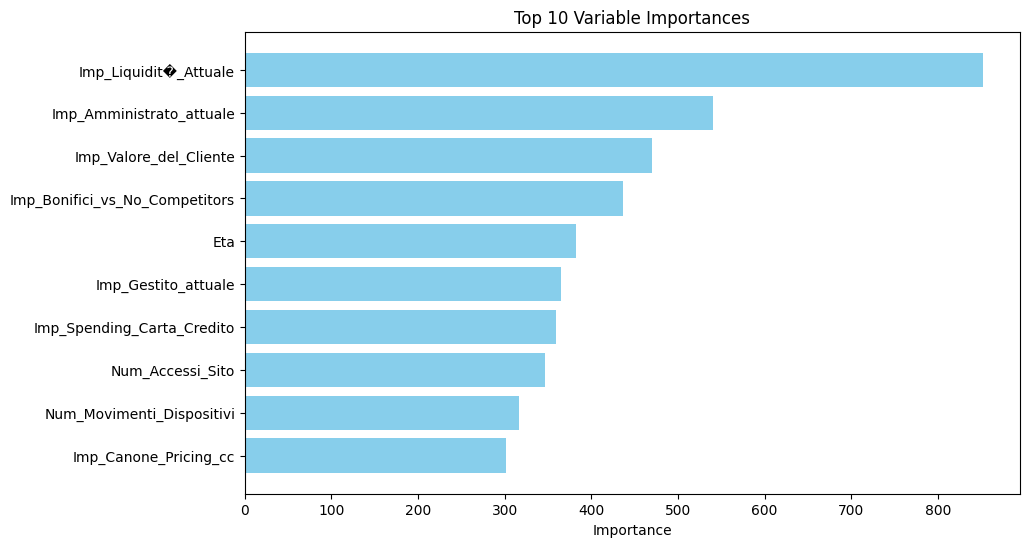

In [15]:
# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train_final.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  
plt.show()

###### We want to see how our final model perform on test set, selecting the top 10k clients with higher probability to be in the minority class

In [18]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': lgbm_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(4000)
print(top_10000_si)

        y_test  y_pred_proba
213385       0      0.983352
117218       0      0.970075
236314       0      0.965924
368493       0      0.963616
17725        1      0.962025
...        ...           ...
108175       0      0.753052
146156       0      0.753014
4891         0      0.753010
193272       0      0.752994
246831       0      0.752976

[4000 rows x 2 columns]


In [19]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 238
Numero di 'SI: nel nostro test set 393


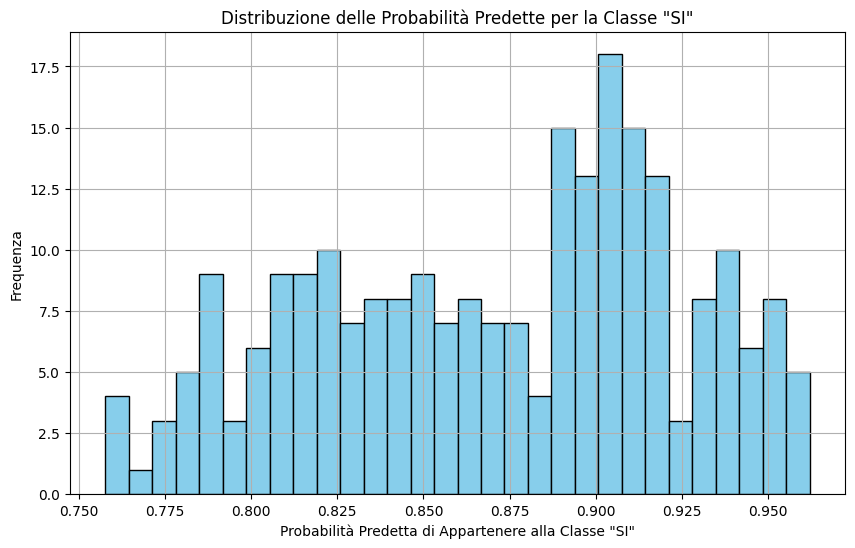

In [20]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

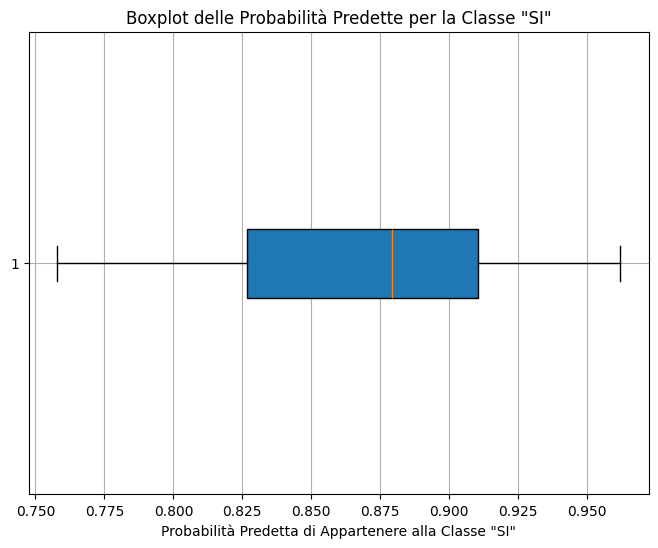

In [21]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

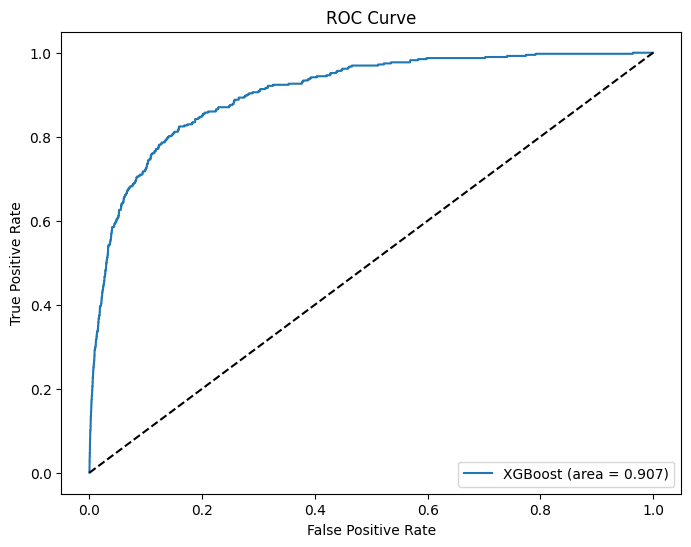

In [22]:
fpr, tpr, thresholds = roc_curve(y_test_final, lgbm_predictions)
auc = roc_auc_score(y_test_final, lgbm_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

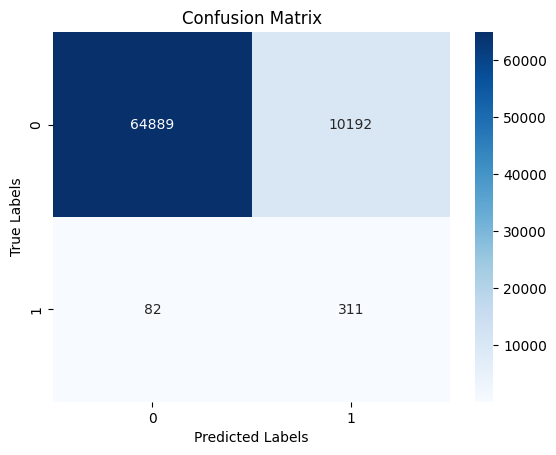

In [23]:
y_pred = best_lgb_classifier.predict(X_test_final)

cm = confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


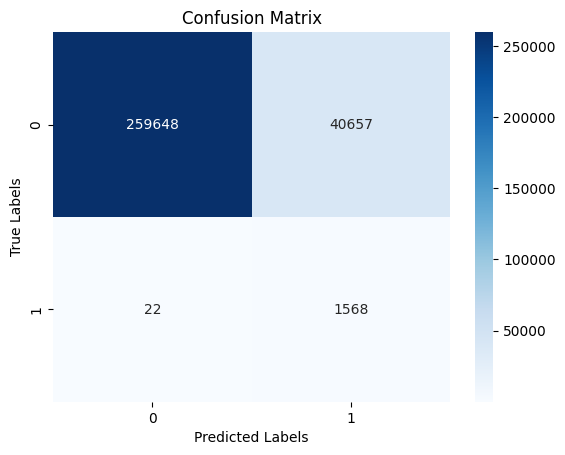

In [187]:
# Train
y_pred = best_lgb_classifier.predict(X_train_final)

cm = confusion_matrix(y_train_final, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

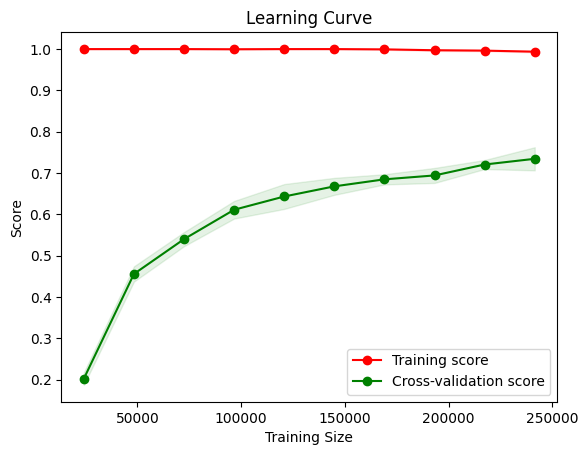

In [24]:
train_sizes, train_scores, test_scores = learning_curve(best_lgb_classifier, X_train, y_train, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

###### The gap between them does not appear to be widening as the training size increases. This suggests that the model is not severely overfitting, as the cross-validation score is improving . The model should be able to generalize on new unseen data, let's see in practice:

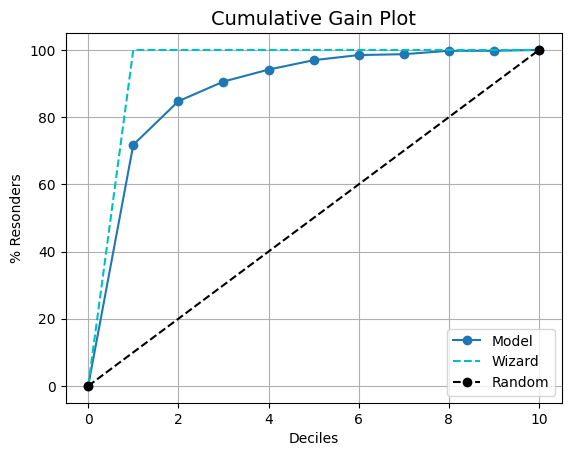

In [27]:
import kds
kds.metrics.plot_cumulative_gain(y_test_final, lgbm_predictions)

##### LightGBM on the syntetic dataset

In [28]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(10000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
38165       0      0.975087
47139       0      0.973162
20410       0      0.972024
40049       0      0.962809
40234       0      0.955535
...       ...           ...
63189       0      0.399658
23077       0      0.399657
54638       0      0.399580
57098       0      0.399536
44251       0      0.399428

[10000 rows x 2 columns]


In [29]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 188
Numero di 'SI: nel nostro test set 489


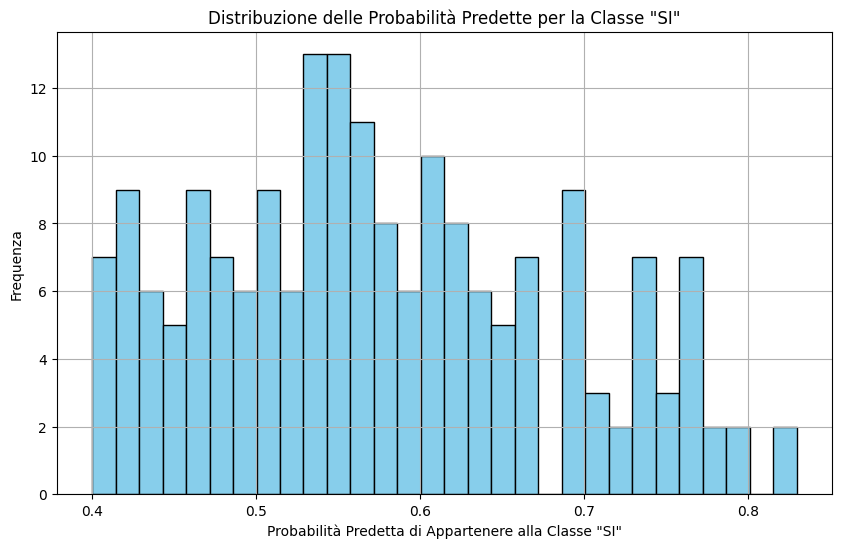

In [30]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

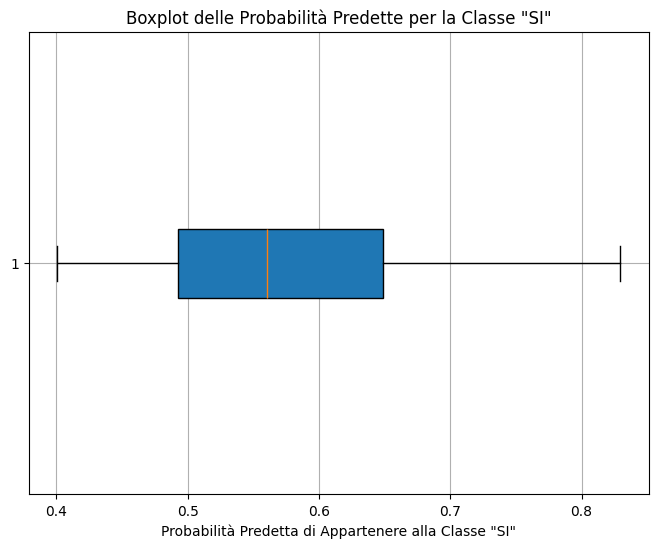

In [31]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

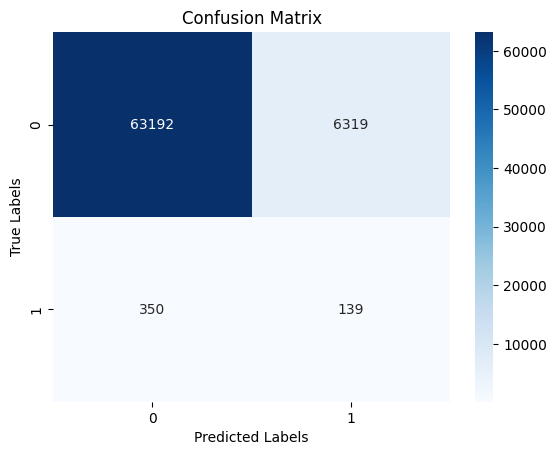

In [32]:
y_pred = best_lgb_classifier.predict(X_train_res_synthetic)

cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### Second Algorithm: XGBoost

In [10]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'scale_pos_weight': scale_pos_weight, 
        'verbosity': 0
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = xgb.XGBClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1] 
        top_indices = np.argsort(probas)[-1698:]  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum() 
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

[I 2024-05-08 13:43:00,831] A new study created in memory with name: no-name-56caaa5c-a949-492c-a8a7-4dc5dea2625c
[I 2024-05-08 13:49:27,554] Trial 0 finished with value: 0.44654088050314467 and parameters: {'n_estimators': 437, 'learning_rate': 0.4123206532618726, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.2904180608409973, 'reg_alpha': 4.330880728874676, 'reg_lambda': 6.051038616257767}. Best is trial 0 with value: 0.44654088050314467.
[I 2024-05-08 13:59:57,678] Trial 1 finished with value: 0.5333333333333334 and parameters: {'n_estimators': 737, 'learning_rate': 0.01083858126934475, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 0.9170225492671691, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 5.295088673159155}. Best is trial 1 with value: 0.5333333333333334.
[I 2024-05-08 14:05:31,171] Trial 2 finished with value: 0.5484276729

Best Hyperparameters: {'n_estimators': 779, 'learning_rate': 0.05230683198500739, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6723675387518698, 'colsample_bytree': 0.8481282797708494, 'gamma': 1.0748305640105353, 'reg_alpha': 1.908194383169251, 'reg_lambda': 5.262797824019152}
Best Score for Top 50,000: 0.5874213836477987


###### Application on XGBoost of the best hyperparameters chosen by Optuna

In [63]:
import xgboost
'''
Best Hyperparameters: {'n_estimators': 661, 'learning_rate': 0.036491004518573594, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 3.1877873567760657, 'reg_alpha': 4.436063712881633, 'reg_lambda': 4.7749277591032975}
Best Score for Top 50,000: 0.829559748427673
'''
# There was a problem with the parameters verbosity, I had to set manually a value in range in main xgboost configuration
xgb.set_config(verbosity=0)
config = xgb.get_config()
assert config['verbosity'] == 0
xgboost.config_context(verbosity=0)
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
xgb_params = {
    'n_estimators': 779,
    'learning_rate': 0.05230683198500739,
    'max_depth': 3,
    'min_child_weight': 3,
    'subsample': 0.6723675387518698,
    'colsample_bytree': 0.8481282797708494,
    'gamma': 1.0748305640105353,
    'reg_alpha': 1.908194383169251,
    'reg_lambda': 5.262797824019152,
    'scale_pos_weight': scale_pos_weight,
}

best_xgb_classifier = xgb.XGBClassifier(verbosity=0, **xgb_params)

best_xgb_classifier.fit(X_train_final, y_train_final)
xgb_predictions = best_xgb_classifier.predict_proba(X_test_final)[:, 1]

###### Feature Importance

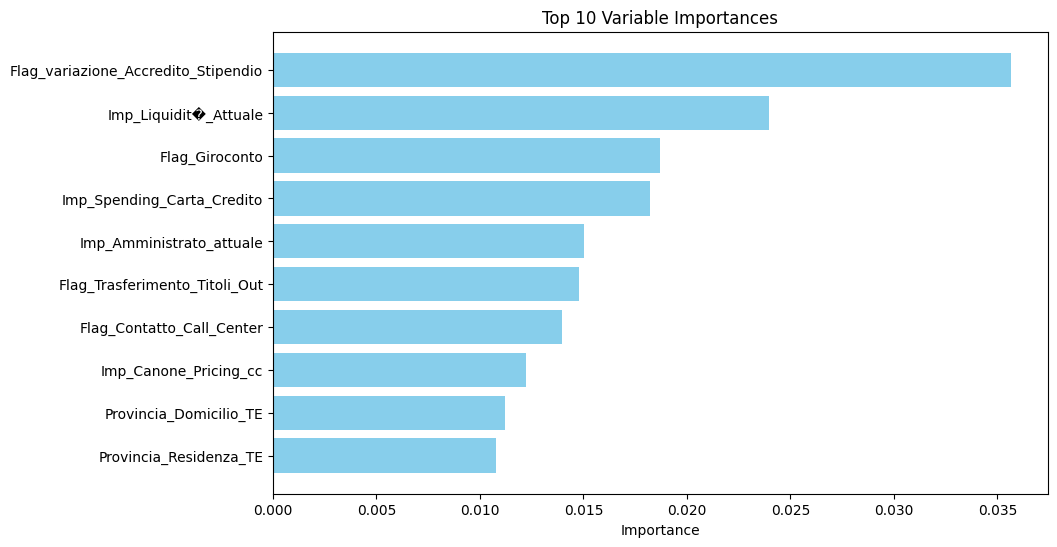

In [34]:
importance = best_xgb_classifier.feature_importances_
features = X_train_final.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis() 
plt.show()


###### Results

In [64]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': xgb_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(4000)
print(top_10000_si)

        y_test  y_pred_proba
288850       0      0.998611
91629        0      0.998292
17678        1      0.998095
236314       0      0.997816
257262       0      0.997811
...        ...           ...
99600        0      0.762464
218598       0      0.762450
61735        0      0.762420
306566       0      0.762387
263941       0      0.762372

[4000 rows x 2 columns]


In [65]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 230
Numero di 'SI: nel nostro test set 393


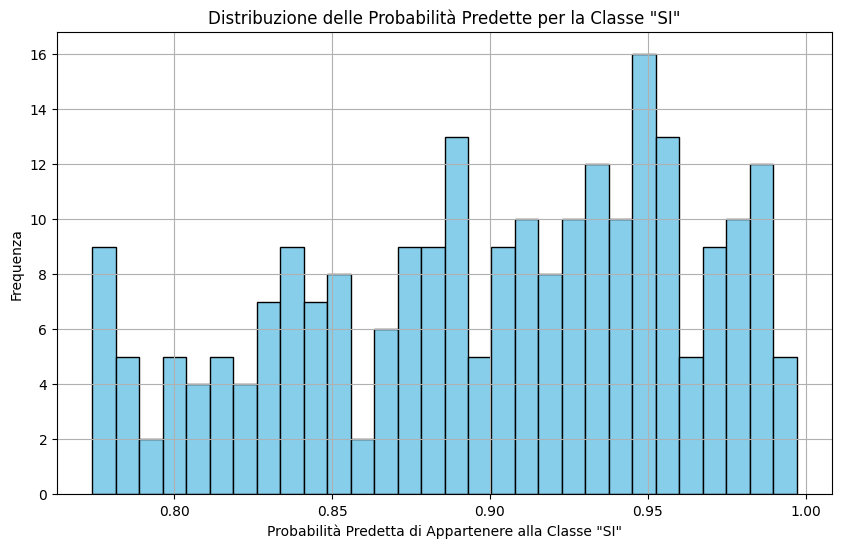

In [53]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

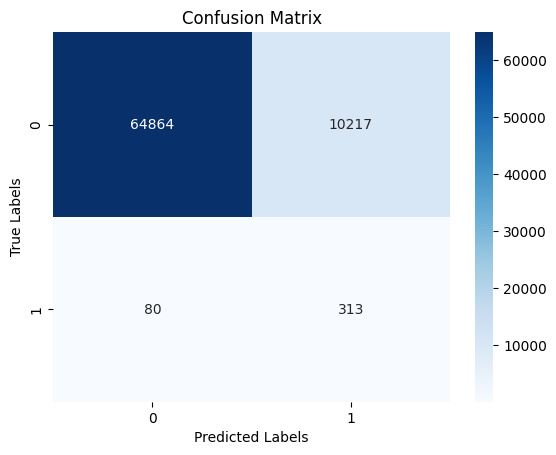

In [188]:
y_pred = best_xgb_classifier.predict(X_test_final)

cm = confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

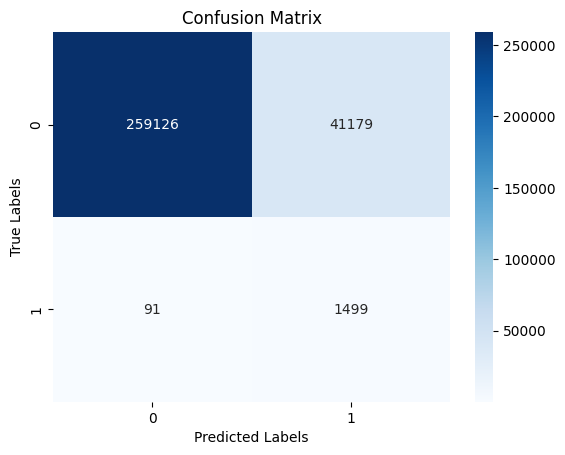

In [190]:
y_pred = best_xgb_classifier.predict(X_train_final)

cm = confusion_matrix(y_train_final, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

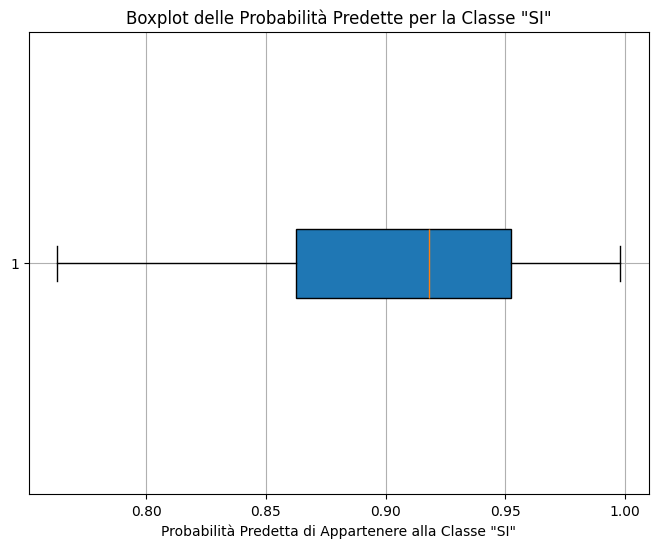

In [67]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

###### It's important to verify if the model is in overfittting. Through the use of the learning curve, we can see in the trained data and the tested data converge: if this happen, the model can summarize good the data, without overfitting. If the two curves remain far, there could be the overfitting risk. The metric used for the comparison is the Recall.

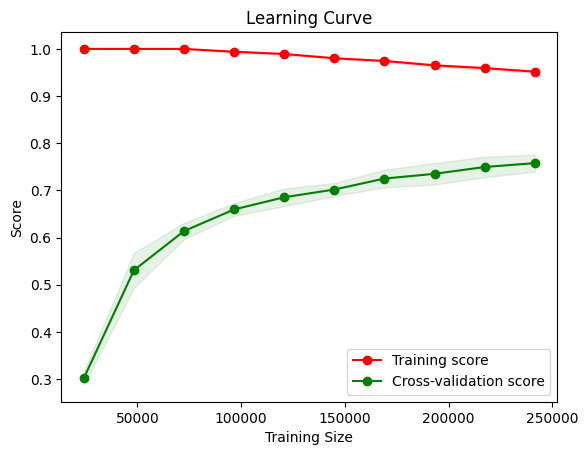

In [17]:
train_sizes, train_scores, test_scores = learning_curve(best_xgb_classifier, X_train_final, y_train_final, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

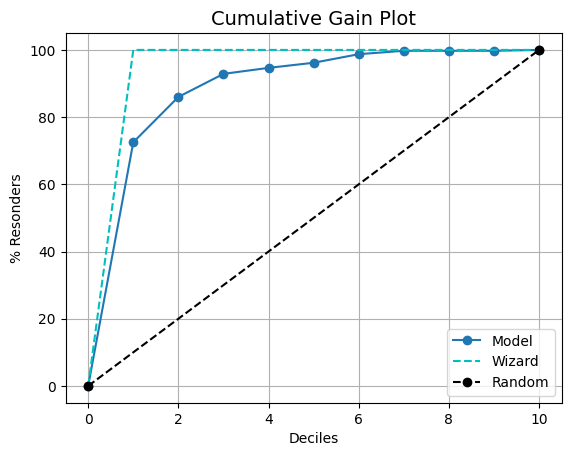

In [68]:
import kds
kds.metrics.plot_cumulative_gain(y_test_final, xgb_predictions)

##### XGBoost on the syntetic dataset

In [69]:
X_train_res_synthetic.rename(columns={
    'Professione_Libero professionista/Titolare impresa': 'Professione_Libero_professionista/Titolare_impresa'
}, inplace=True)
#missmatch between column_names

In [70]:
xgb_predictions = best_xgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': xgb_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(4000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
20713       0      0.950189
41056       0      0.949418
44462       0      0.947188
62547       0      0.938932
6352        0      0.917699
...       ...           ...
42430       0      0.382303
52911       0      0.382288
26333       0      0.382212
54782       0      0.382170
21373       0      0.382144

[4000 rows x 2 columns]


In [71]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 55
Numero di 'SI: nel nostro test set 489


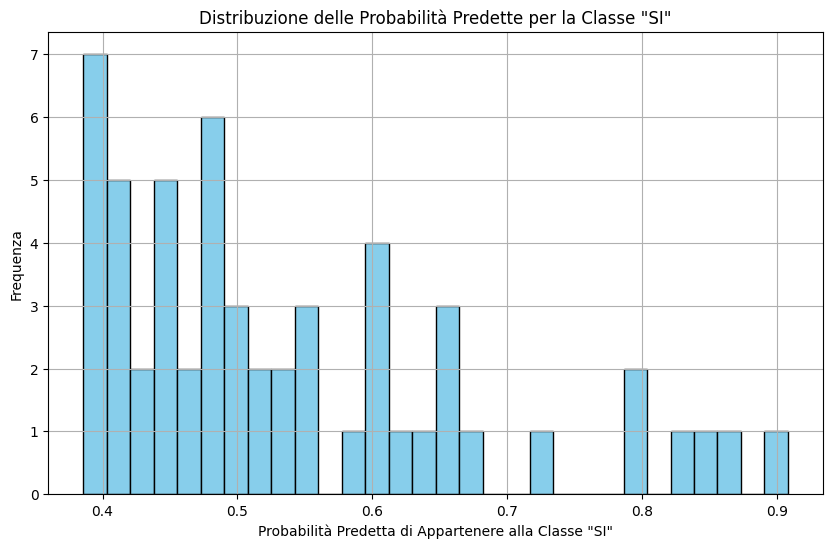

In [72]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

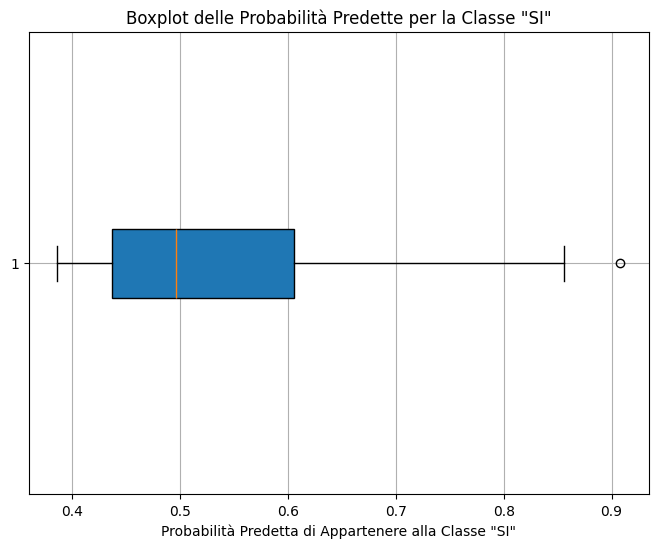

In [73]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

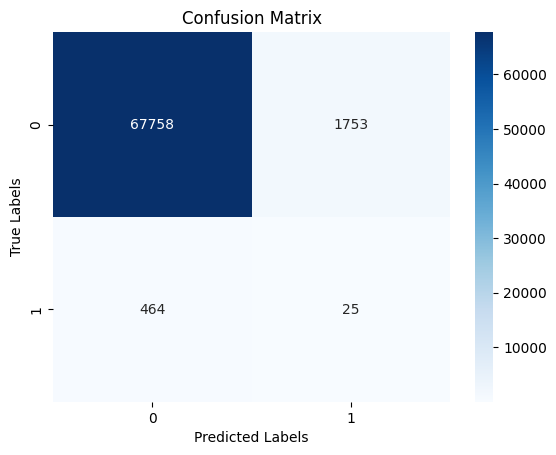

In [74]:
y_pred = best_xgb_classifier.predict(X_train_res_synthetic)

cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Third Alghoritm: Catboost

In [51]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'scale_pos_weight': scale_pos_weight, 
        'verbose': False
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = cb.CatBoostClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1] 
        top_indices = np.argsort(probas)[-1698:]  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum() 
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

[I 2024-05-08 20:02:11,662] A new study created in memory with name: no-name-9103109e-f0e4-4ae4-a6a1-9c5578608dea


[I 2024-05-08 20:08:16,044] Trial 0 finished with value: 0.5647798742138366 and parameters: {'n_estimators': 250, 'learning_rate': 0.17254716573280354, 'max_depth': 13, 'l2_leaf_reg': 5.986986183486169, 'border_count': 66, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 8, 'leaf_estimation_method': 'Gradient'}. Best is trial 0 with value: 0.5647798742138366.
[I 2024-05-08 20:10:58,664] Trial 1 finished with value: 0.5245283018867924 and parameters: {'n_estimators': 433, 'learning_rate': 0.018891200276189388, 'max_depth': 7, 'l2_leaf_reg': 1.8348616940244846, 'border_count': 100, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Gradient'}. Best is trial 0 with value: 0.5647798742138366.
[I 2024-05-08 20:14:36,503] Trial 2 finished with value: 0.5339622641509434 and parameters: {'n_estimators': 282, 'learning_rate': 0.10508421338691762, 'max_depth': 7, 'l2_leaf_reg': 5.142830149697703, 'b

Best Hyperparameters: {'n_estimators': 329, 'learning_rate': 0.05194348975504665, 'max_depth': 14, 'l2_leaf_reg': 7.9578314783147945, 'border_count': 188, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 6, 'leaf_estimation_method': 'Gradient'}
Best Score for Top 50,000: 0.5830188679245283


In [96]:
'''
Best Hyperparameters: {'n_estimators': 486, 'learning_rate': 0.08564115269968339, 'max_depth': 5, 'l2_leaf_reg': 5.495063193351241, 'border_count': 113, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 9, 'leaf_estimation_method': 'Gradient'}
Best Score for Top 50,000: 0.8327044025157233
'''
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

catboost_params = {
    'n_estimators': 329,
    'learning_rate': 0.05194348975504665,
    'max_depth': 14,
    'l2_leaf_reg': 7.9578314783147945,
    'border_count': 188,
    'grow_policy': 'Lossguide',
    'min_data_in_leaf': 29,
    'leaf_estimation_iterations': 6,
    'leaf_estimation_method': 'Gradient',
    'scale_pos_weight': scale_pos_weight,
}

best_catboost_classifier = cb.CatBoostClassifier(**catboost_params)

best_catboost_classifier.fit(X_train_final, y_train_final)
catboost_predictions = best_catboost_classifier.predict_proba(X_test_final)[:, 1]


0:	learn: 0.6784493	total: 88ms	remaining: 28.8s
1:	learn: 0.6636944	total: 180ms	remaining: 29.4s
2:	learn: 0.6525467	total: 243ms	remaining: 26.4s
3:	learn: 0.6410767	total: 310ms	remaining: 25.2s
4:	learn: 0.6287441	total: 402ms	remaining: 26s
5:	learn: 0.6192176	total: 504ms	remaining: 27.1s
6:	learn: 0.6092144	total: 592ms	remaining: 27.2s
7:	learn: 0.5991113	total: 674ms	remaining: 27s
8:	learn: 0.5893811	total: 761ms	remaining: 27s
9:	learn: 0.5807489	total: 840ms	remaining: 26.8s
10:	learn: 0.5718687	total: 925ms	remaining: 26.7s
11:	learn: 0.5652896	total: 996ms	remaining: 26.3s
12:	learn: 0.5588523	total: 1.07s	remaining: 26.1s
13:	learn: 0.5519782	total: 1.15s	remaining: 25.9s
14:	learn: 0.5455077	total: 1.23s	remaining: 25.7s
15:	learn: 0.5394442	total: 1.32s	remaining: 25.9s
16:	learn: 0.5347757	total: 1.4s	remaining: 25.7s
17:	learn: 0.5291124	total: 1.48s	remaining: 25.6s
18:	learn: 0.5241745	total: 1.57s	remaining: 25.6s
19:	learn: 0.5198730	total: 1.65s	remaining: 25.5

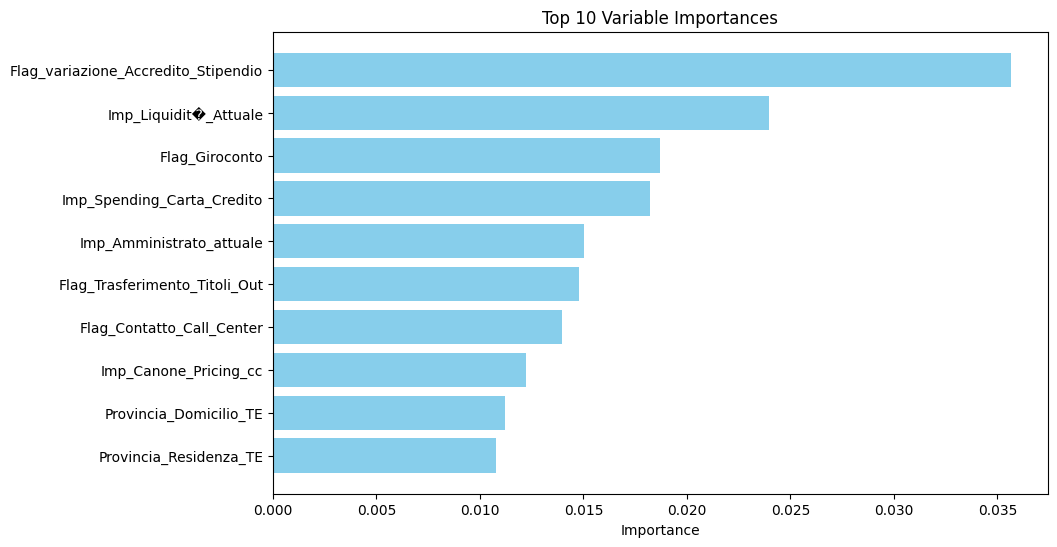

In [76]:
importance = best_xgb_classifier.feature_importances_
features = X_train_final.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


In [97]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': catboost_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(4000)
print(top_10000_si)

        y_test  y_pred_proba
288850       0      0.988678
91629        0      0.986011
25853        1      0.985830
117164       0      0.984374
17678        1      0.983631
...        ...           ...
164166       0      0.760716
172759       0      0.760694
48330        0      0.760683
298809       0      0.760618
345245       0      0.760567

[4000 rows x 2 columns]


In [98]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 237
Numero di 'SI: nel nostro test set 393


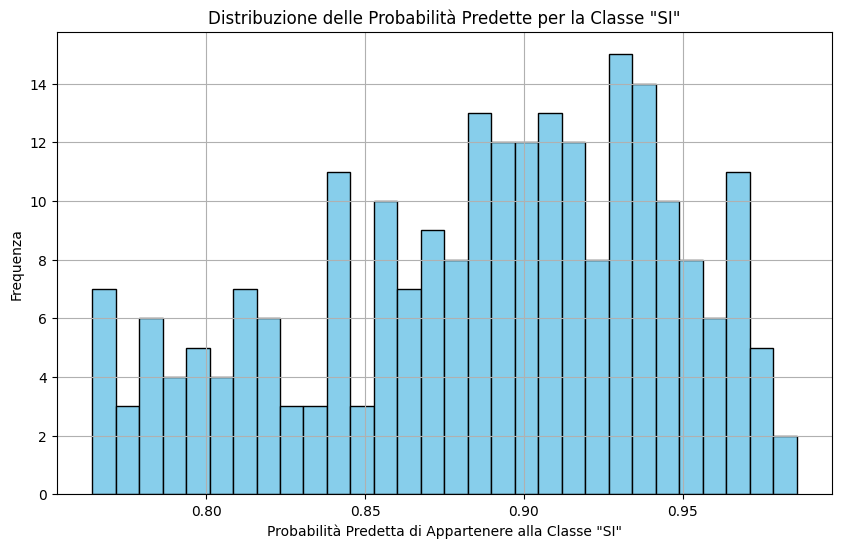

In [99]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

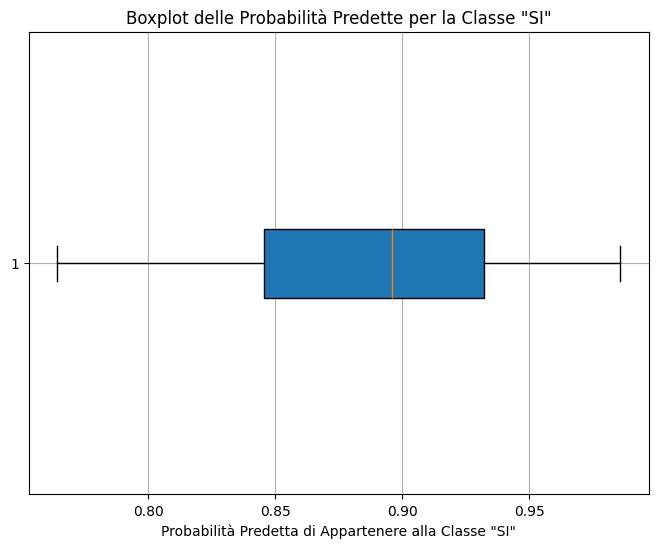

In [100]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

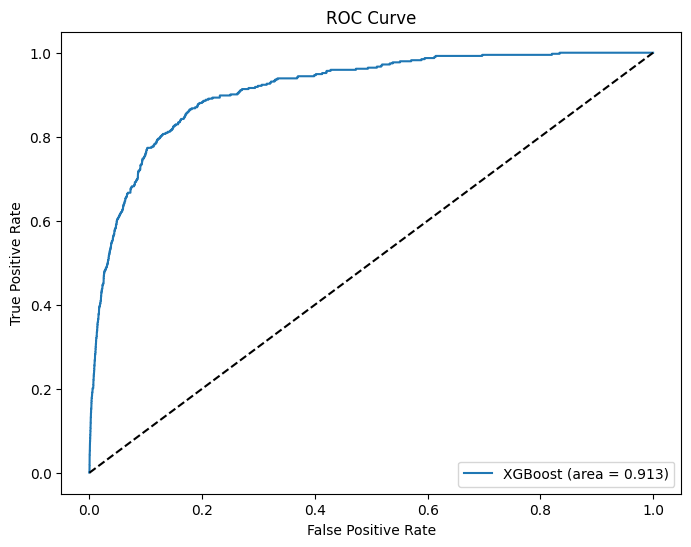

In [101]:
fpr, tpr, thresholds = roc_curve(y_test_final, catboost_predictions)
auc = roc_auc_score(y_test_final, catboost_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

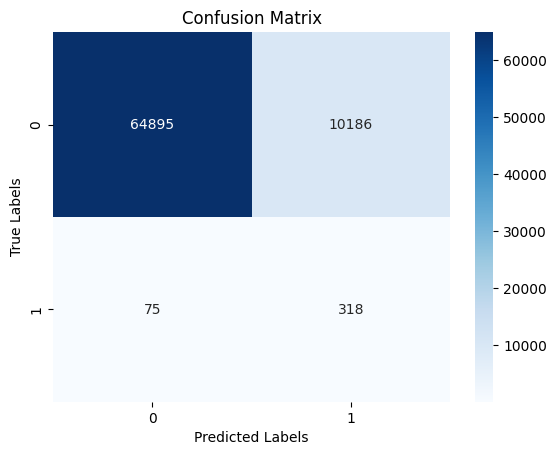

In [102]:
y_pred = best_catboost_classifier.predict(X_test_final)

cm = confusion_matrix(y_test_final, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


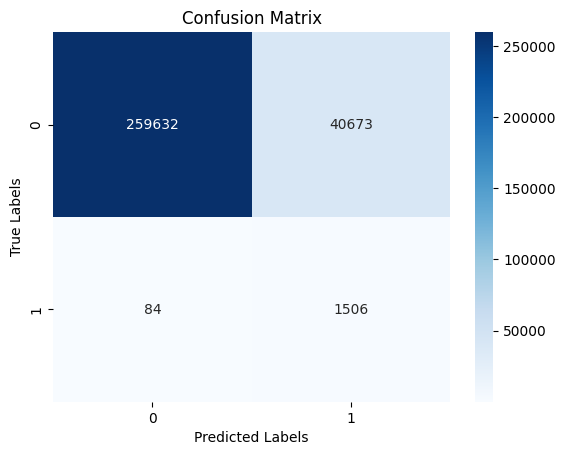

In [191]:
y_pred = best_catboost_classifier.predict(X_train_final)

cm = confusion_matrix(y_train_final, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

0:	learn: 0.6781302	total: 288ms	remaining: 1m 34s
1:	learn: 0.6664707	total: 344ms	remaining: 56.3s
0:	learn: 0.6773277	total: 817ms	remaining: 4m 27s
2:	learn: 0.6526556	total: 1.03s	remaining: 1m 52s
3:	learn: 0.6422168	total: 1.38s	remaining: 1m 52s
1:	learn: 0.6638852	total: 1.39s	remaining: 3m 46s
0:	learn: 0.6761658	total: 788ms	remaining: 4m 18s
4:	learn: 0.6299851	total: 1.73s	remaining: 1m 52s
5:	learn: 0.6160098	total: 2.12s	remaining: 1m 54s
2:	learn: 0.6522975	total: 2.06s	remaining: 3m 44s
6:	learn: 0.6041134	total: 2.4s	remaining: 1m 50s
0:	learn: 0.6788235	total: 1.12s	remaining: 6m 8s
1:	learn: 0.6628268	total: 1.72s	remaining: 4m 41s
3:	learn: 0.6401410	total: 2.41s	remaining: 3m 15s
0:	learn: 0.6815881	total: 903ms	remaining: 4m 56s
7:	learn: 0.5929983	total: 2.65s	remaining: 1m 46s
8:	learn: 0.5864851	total: 3s	remaining: 1m 46s
4:	learn: 0.6301343	total: 2.81s	remaining: 3m 2s
1:	learn: 0.6647495	total: 1.68s	remaining: 4m 34s
2:	learn: 0.6498625	total: 2.17s	remai

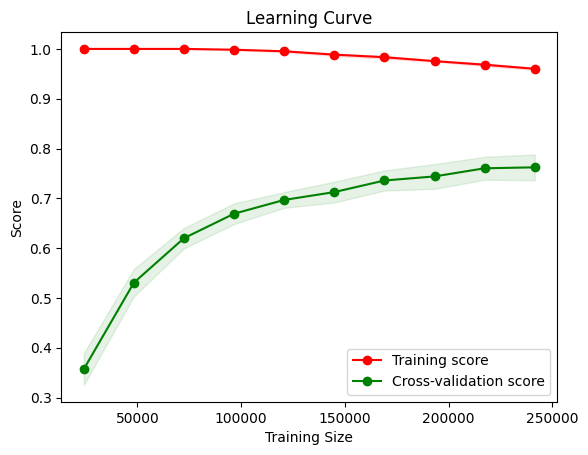

In [60]:
train_sizes, train_scores, test_scores = learning_curve(best_catboost_classifier, X_train_final, y_train_final, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

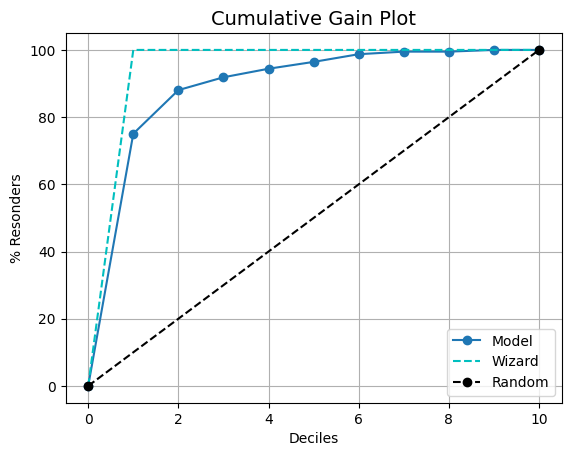

In [103]:
kds.metrics.plot_cumulative_gain(y_test_final, catboost_predictions)

##### Catboost on the syntethic dataset

In [86]:
catboost_predictions = best_catboost_classifier.predict_proba(X_train_res_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': catboost_predictions

})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(4000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
25443       0      0.954592
27549       0      0.951690
39581       0      0.946339
54195       0      0.943586
35766       1      0.941504
...       ...           ...
38718       0      0.667453
25475       0      0.667434
60627       0      0.667421
32564       0      0.667384
47382       0      0.667357

[4000 rows x 2 columns]


In [87]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 113
Numero di 'SI: nel nostro test set 489


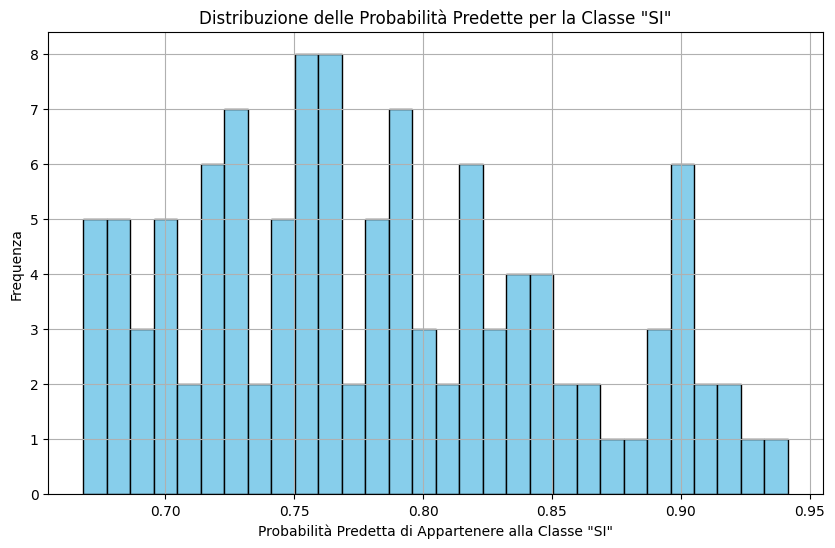

In [88]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

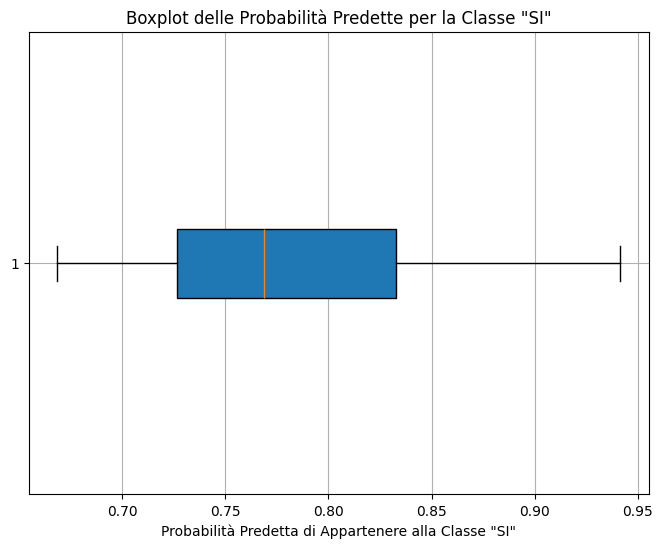

In [89]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

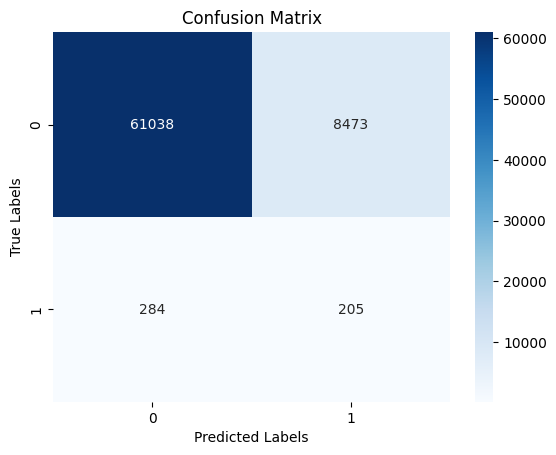

In [90]:
y_pred = best_catboost_classifier.predict(X_train_synthetic)

cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Forth Method: 'Merging' of the previous three methods with a respective weight

In [104]:
def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    weight_catboost = trial.suggest_float('weight_catboost', 0, 1)
    weight_xgb = trial.suggest_float('weight_xgb', 0, 1 - weight_catboost)

    # Calculate weight for LightGBM as the remainder
    weight_lgbm = 1 - weight_catboost - weight_xgb

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        catboost_predictions = best_catboost_classifier.predict_proba(X_fold_val)[:, 1]
        xgb_predictions = best_xgb_classifier.predict_proba(X_fold_val)[:, 1]
        lgbm_predictions = best_lgb_classifier.predict_proba(X_fold_val)[:, 1]
        ensemble_predictions = (weight_catboost * catboost_predictions) + (weight_xgb * xgb_predictions) + (weight_lgbm * lgbm_predictions)

        top_indices = np.argsort(ensemble_predictions)[-1698:]  
        top_positives = y_fold_val.iloc[top_indices].sum() 
        total_positives = y_fold_val.sum() 
        scores.append(top_positives / total_positives if total_positives > 0 else 0)  

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)


history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

[I 2024-05-09 12:31:44,442] A new study created in memory with name: no-name-fd3b7cb4-cb59-4067-af5b-7a269704fe5e
[I 2024-05-09 12:31:55,610] Trial 0 finished with value: 0.7276729559748427 and parameters: {'weight_catboost': 0.3745401188473625, 'weight_xgb': 0.5946336570972584}. Best is trial 0 with value: 0.7276729559748427.
[I 2024-05-09 12:32:07,284] Trial 1 finished with value: 0.7251572327044026 and parameters: {'weight_catboost': 0.7319939418114051, 'weight_xgb': 0.16044410055080702}. Best is trial 0 with value: 0.7276729559748427.
[I 2024-05-09 12:32:18,170] Trial 2 finished with value: 0.759119496855346 and parameters: {'weight_catboost': 0.15601864044243652, 'weight_xgb': 0.1316564673568783}. Best is trial 2 with value: 0.759119496855346.
[I 2024-05-09 12:32:28,858] Trial 3 finished with value: 0.7257861635220125 and parameters: {'weight_catboost': 0.05808361216819946, 'weight_xgb': 0.815865506454398}. Best is trial 2 with value: 0.759119496855346.
[I 2024-05-09 12:32:40,034]

Best Hyperparameters: {'weight_catboost': 0.00770986933533484, 'weight_xgb': 0.002451552254150141}
Best Score for Top 50,000: 0.7716981132075473


In [174]:
# Manually set the weight
weight_catboost = 0.65
weight_xgb = 0.05
weight_lgbm = 0.3

In [175]:
catboost_predictions = best_catboost_classifier.predict_proba(X_test_final)[:, 1]
xgb_predictions = best_xgb_classifier.predict_proba(X_test_final)[:, 1]
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]

ensemble_predictions = (weight_catboost * catboost_predictions) + (weight_xgb * xgb_predictions) + (weight_lgbm * lgbm_predictions)

In [176]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': ensemble_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(4000)
print(top_10000_si)

        y_test  y_pred_proba
288850       0      0.979620
25853        1      0.978095
17678        1      0.977845
236314       0      0.976896
91629        0      0.976709
...        ...           ...
33804        0      0.751202
228934       0      0.751191
101159       0      0.751170
312495       0      0.751155
186265       0      0.751135

[4000 rows x 2 columns]


In [177]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 243
Numero di 'SI: nel nostro test set 393


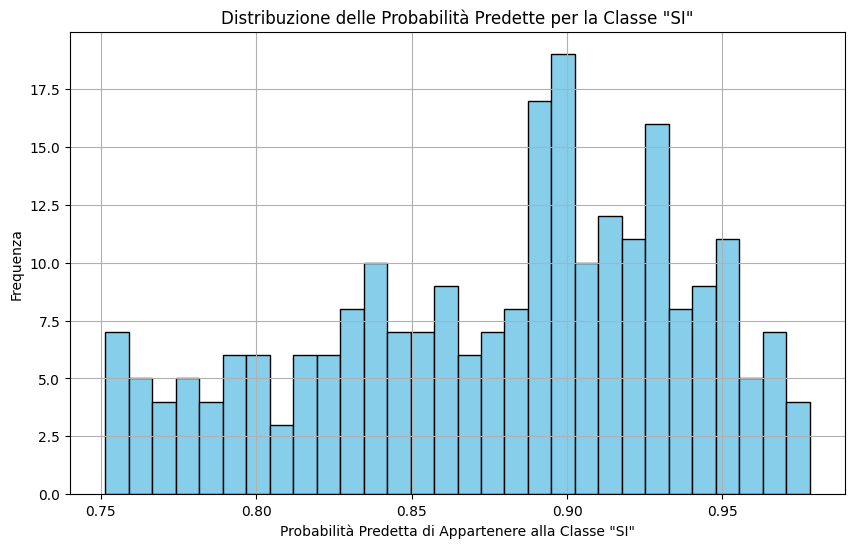

In [178]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

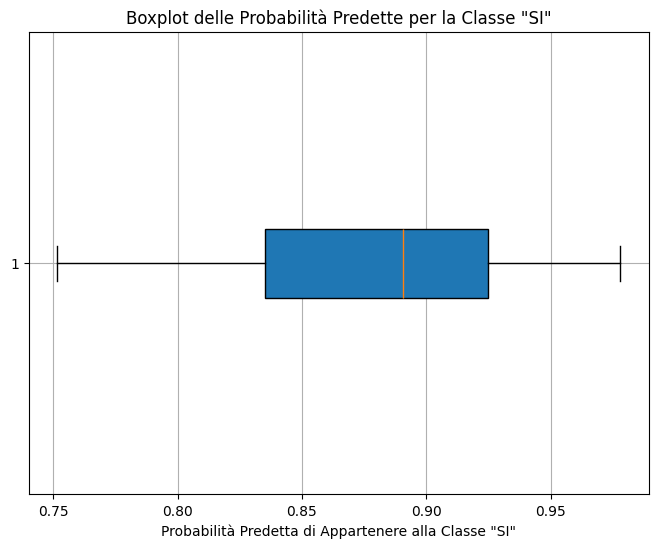

In [179]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

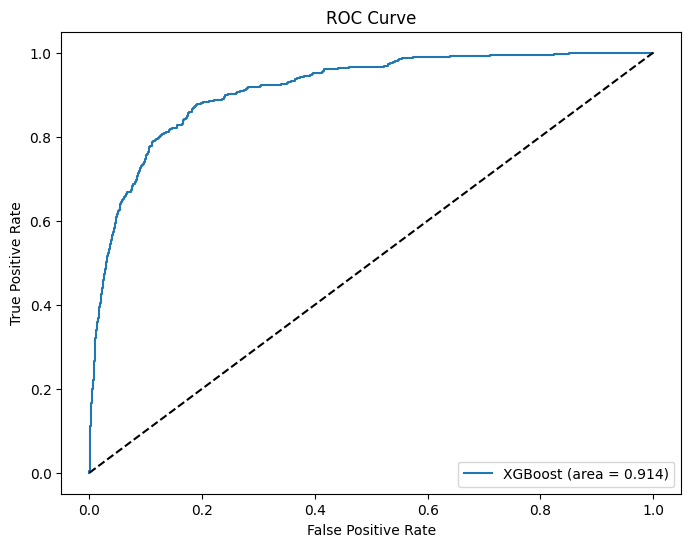

In [180]:
fpr, tpr, thresholds = roc_curve(y_test, ensemble_predictions)
auc = roc_auc_score(y_test, ensemble_predictions)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

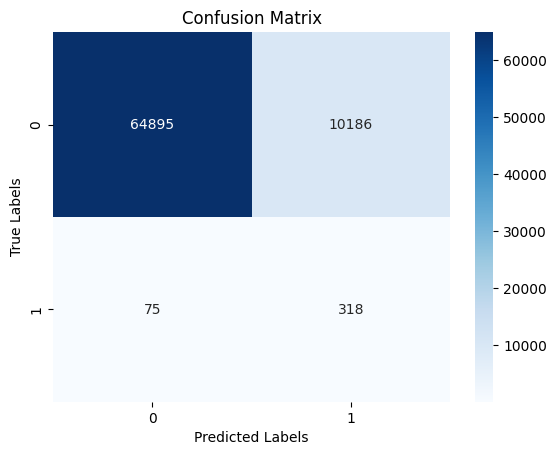

In [151]:
catboost_pred = best_catboost_classifier.predict(X_test_final)
xgb_pred = best_xgb_classifier.predict(X_test_final)
lgbm_pred = best_lgb_classifier.predict(X_test_final)

y_pred = (weight_catboost * catboost_pred) + (weight_xgb * xgb_pred) + (weight_lgbm * lgbm_pred)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(y_test_final, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

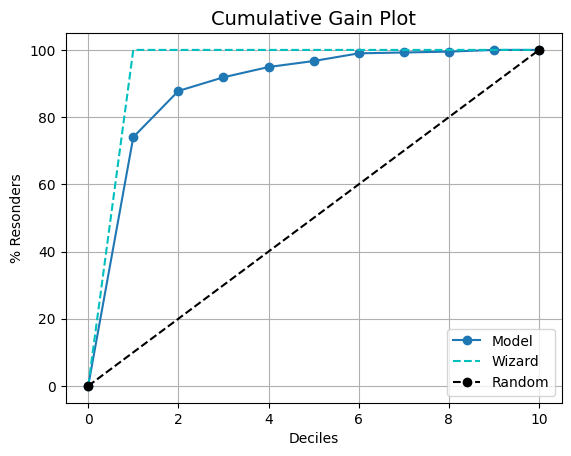

In [152]:
kds.metrics.plot_cumulative_gain(y_test_final, ensemble_predictions)


##### Merged alghorithms on the Synthetic dataset

In [183]:
xgb_predictions_synt = best_xgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
lgbm_predictions_synt = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
catboost_predictions_synt = best_catboost_classifier.predict_proba(X_train_res_synthetic)[:, 1]
ensemble_predictions_synth = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': ensemble_predictions_synth

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(4000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
25443       0      0.928113
50396       0      0.913547
2863        0      0.912142
64179       0      0.905252
11542       0      0.901692
...       ...           ...
62758       0      0.602914
58025       0      0.602807
58709       1      0.602786
1229        0      0.602777
43859       0      0.602759

[4000 rows x 2 columns]


In [184]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 114
Numero di 'SI: nel nostro test set 489


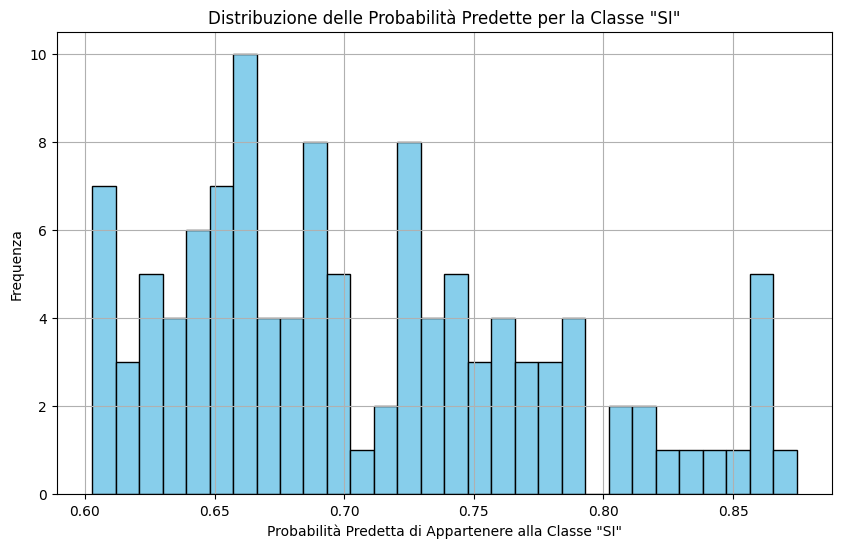

In [185]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

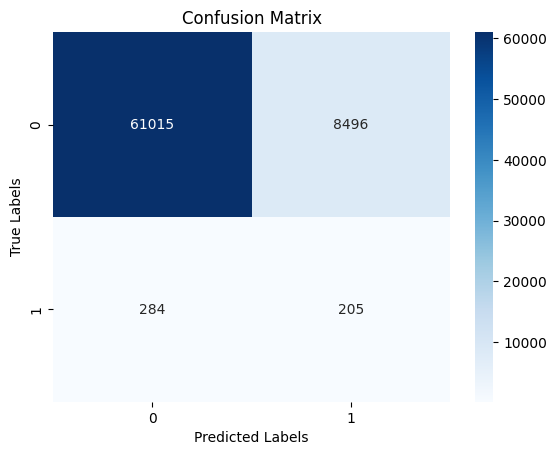

In [186]:
xgb_predictions_synt = best_xgb_classifier.predict(X_train_res_synthetic)
lgbm_predictions_synt = best_lgb_classifier.predict(X_train_res_synthetic)
catboost_predictions_synt = best_catboost_classifier.predict(X_train_res_synthetic)
ensemble_predictions_synth = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)

y_pred_binary = np.where(ensemble_predictions_synth > 0.5, 1, 0)

cm = confusion_matrix(y_synthetic, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

.